In [1]:
!pip install -q torchinfo
!pip install -q wandb
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import wandb
from wandb.integration import torch as wandb_torch
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.constraints import max_norm
from tensorflow import keras

In [15]:
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/HW02-Practical


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/HW02-Practical


In [3]:
dataset_train1 = tf.keras.utils.image_dataset_from_directory('Dataset/train')
dataset_test1 = tf.keras.utils.image_dataset_from_directory('Dataset/test')
dataset_valid1 = tf.keras.utils.image_dataset_from_directory('Dataset/valid')

Found 15021 files belonging to 5 classes.
Found 5116 files belonging to 5 classes.
Found 5010 files belonging to 5 classes.


In [4]:
# resize
image_size = (28, 28)
dataset_train = dataset_train1.map(lambda x, y: (tf.image.resize(x, image_size), y))
dataset_test = dataset_test1.map(lambda x, y: (tf.image.resize(x, image_size), y))
dataset_valid = dataset_valid1.map(lambda x, y: (tf.image.resize(x, image_size), y))

In [5]:
img_width, img_height         = 28, 28
batch_size                    = 250
no_epochs                     = 10
no_classes                    = 5
verbosity                     = 1
max_norm_value                = 2.0
input_shape = (img_width  , img_height, 3)


In [6]:
def show_model_results_loss_train(history):
   
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [34]:
def show_model_results_loss_valid(history):
   
    val_loss = history.history['val_loss']
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

# قسمت آ

#### underfit model

 زمانی اتفاق می افتد که مدل بیش از حد ساده باشد و در کل عملکرد بدی داشته باشد و خطا هم روی داده های آموزشی و هم روی آزمایشی زیاد باشد به عنوان مثال اگر برای یک مجموعه ی تصویر مدل خطی یا یک مدل خیلی ساده را در نظر بگیریم به احتمال زیاد باعث این اتفاق میشویم همچنین زمانی که در شبکه برای جلوگیری از بیش برازش برخی نورون ها را حذف میکنیم اگر زیاد این کار را انجام دهیم نیز با مشکل مواجه میشویم در واقع دراپ اوت میتواند باعث آندرفیت شدن هم شود 

In [ ]:
# create model
underfit_model = Sequential()
underfit_model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', input_shape=input_shape))
underfit_model.add(MaxPooling2D(pool_size=(2, 2)))
underfit_model.add(Dropout(0.8))
underfit_model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu'))
underfit_model.add(MaxPooling2D(pool_size=(2, 2)))
underfit_model.add(Dropout(0.8))
underfit_model.add(Flatten())
underfit_model.add(Dense(256, activation='relu', kernel_constraint=max_norm(max_norm_value)))
underfit_model.add(Dense(no_classes, activation='softmax'))


In [ ]:
opt = keras.optimizers.Adam()
underfit_model.compile(
  optimizer=opt,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


In [ ]:
results = underfit_model.fit(
  dataset_train,
  validation_data=dataset_valid,
  epochs=10
)

Epoch 1/10
470/470 [==============================] - 118s 233ms/step - loss: 256.5605 - accuracy: 0.2075 - val_loss: 1.6098 - val_accuracy: 0.2016
Epoch 2/10
470/470 [==============================] - 113s 240ms/step - loss: 1.6247 - accuracy: 0.2204 - val_loss: 1.6096 - val_accuracy: 0.1996
Epoch 3/10
470/470 [==============================] - 116s 245ms/step - loss: 1.6131 - accuracy: 0.2166 - val_loss: 1.6095 - val_accuracy: 0.1996
Epoch 4/10
470/470 [==============================] - 114s 242ms/step - loss: 1.6085 - accuracy: 0.2121 - val_loss: 1.6095 - val_accuracy: 0.1996
Epoch 5/10
470/470 [==============================] - 114s 242ms/step - loss: 1.6077 - accuracy: 0.2116 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 6/10
470/470 [==============================] - 105s 222ms/step - loss: 1.6080 - accuracy: 0.2130 - val_loss: 1.6094 - val_accuracy: 0.1998
Epoch 7/10
470/470 [==============================] - 104s 221ms/step - loss: 1.6040 - accuracy: 0.2116 - val_loss: 1.6093

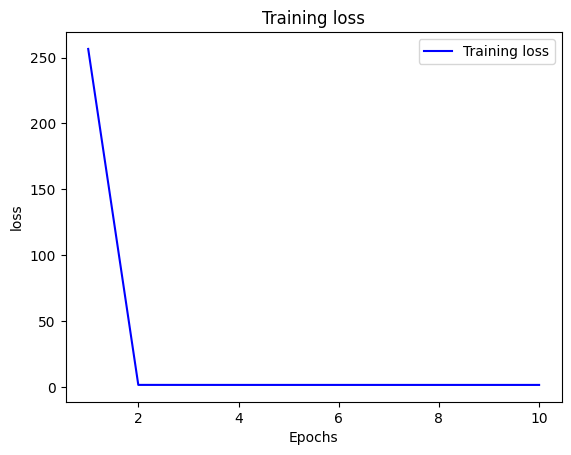

In [ ]:
show_model_results_loss_train(results)

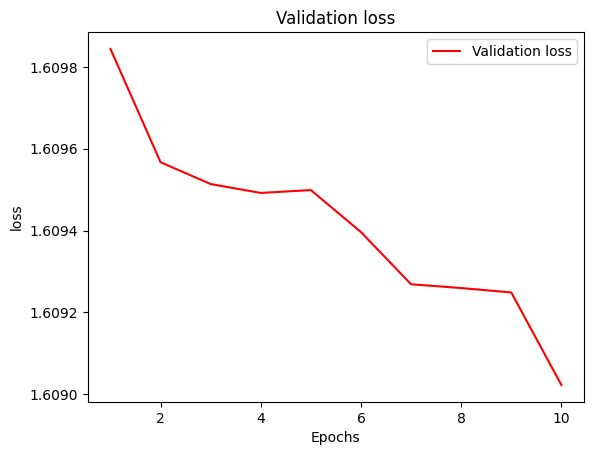

In [ ]:
show_model_results_loss_valid(results)

همان طور که مبینیم خطا کاهش یافته است اما چون مدل بیسیار ساده است دقت خوبی ندارد و مناسب نیست

# قسمت ب

## overfit model

در سناریوی قبلی مقدار دارپ اوت خیلی زیاد بود و نورون ها با احتمال زیاد حذف میشدند و شبکه خیلی ساده میشد حال مقدار آن را خیلی کم میکنیم

In [8]:
overfit_model = Sequential()
overfit_model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', input_shape=input_shape))
overfit_model.add(MaxPooling2D(pool_size=(2, 2)))
overfit_model.add(Dropout(0.0001))
overfit_model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu'))
overfit_model.add(MaxPooling2D(pool_size=(2, 2)))
overfit_model.add(Dropout(0.0001))
overfit_model.add(Flatten())
overfit_model.add(Dense(256, activation='relu', kernel_constraint=max_norm(max_norm_value)))
overfit_model.add(Dense(no_classes, activation='softmax'))

In [9]:
opt = keras.optimizers.Adam()
overfit_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


In [10]:
results = overfit_model.fit(
  dataset_train,
  validation_data=dataset_valid,
  epochs=10
)

Epoch 1/10
470/470 [==============================] - 1588s 3s/step - loss: 2.0942 - accuracy: 0.5424 - val_loss: 1.0295 - val_accuracy: 0.6030
Epoch 2/10
470/470 [==============================] - 52s 110ms/step - loss: 0.8566 - accuracy: 0.6785 - val_loss: 0.8881 - val_accuracy: 0.6780
Epoch 3/10
470/470 [==============================] - 52s 110ms/step - loss: 0.6616 - accuracy: 0.7577 - val_loss: 0.7519 - val_accuracy: 0.7497
Epoch 4/10
470/470 [==============================] - 50s 106ms/step - loss: 0.5176 - accuracy: 0.8157 - val_loss: 0.7803 - val_accuracy: 0.7483
Epoch 5/10
470/470 [==============================] - 51s 107ms/step - loss: 0.4236 - accuracy: 0.8509 - val_loss: 0.7676 - val_accuracy: 0.7651
Epoch 6/10
470/470 [==============================] - 50s 106ms/step - loss: 0.3363 - accuracy: 0.8805 - val_loss: 0.8616 - val_accuracy: 0.7557
Epoch 7/10
470/470 [==============================] - 51s 107ms/step - loss: 0.2809 - accuracy: 0.9000 - val_loss: 0.8508 - val_acc

همان طور که میبینیم دقت در این مدل افزایش یافته است اما یک مدل پیچیده داریم

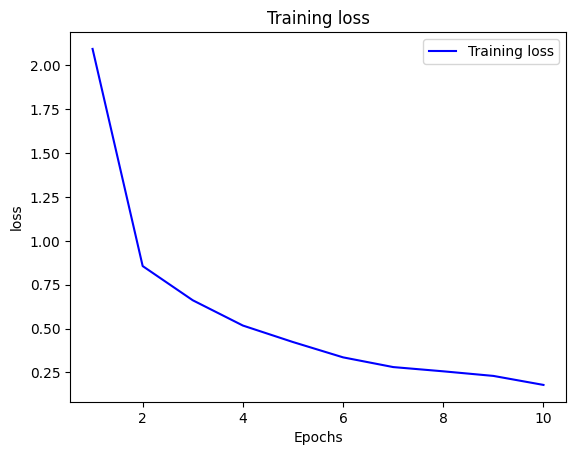

In [11]:
show_model_results_loss_train(results)

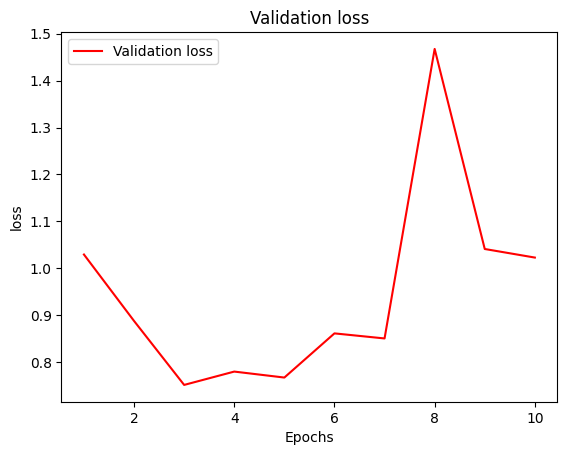

In [12]:
show_model_results_loss_valid(results)

In [13]:
overfit_model.save('/content/gdrive/MyDrive/HW02-Practical/overfitmodel.h5')

In [19]:
with open('/content/gdrive/MyDrive/HW02-Practical/overfit_training.pkl', 'wb') as file:
    pickle.dump(results, file)

# قسمت ج

### اصلاح مدل با تغییر نرخ نگهداری
در سناریوی اول مقدار آن زیاد بود و در نتیجه نورون های زیادی حذف شدند و مدل به شدت ساده شد در سناریوی دوم مقدار آن خیلی کم بود و یک شبکه ی پیچیده داشتیم که باعث بیش برازش شده بود در این مدل مقدار آن را به یک مقدار مناسب تغییر میدهیم

In [20]:
best_model = Sequential()
best_model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu', input_shape=input_shape))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.3))
best_model.add(Conv2D(64, kernel_size=(3, 3), kernel_constraint=max_norm(max_norm_value), activation='relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Dropout(0.3))
best_model.add(Flatten())
best_model.add(Dense(256, activation='relu', kernel_constraint=max_norm(max_norm_value)))
best_model.add(Dense(no_classes, activation='softmax'))


In [21]:
best_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


In [22]:
results2 = best_model.fit(
  dataset_train,
  validation_data=dataset_valid,
  epochs=10
)

Epoch 1/10
470/470 [==============================] - 53s 108ms/step - loss: 3.1784 - accuracy: 0.2691 - val_loss: 1.5654 - val_accuracy: 0.2701
Epoch 2/10
470/470 [==============================] - 53s 111ms/step - loss: 1.4002 - accuracy: 0.4355 - val_loss: 1.2224 - val_accuracy: 0.5060
Epoch 3/10
470/470 [==============================] - 51s 108ms/step - loss: 1.1250 - accuracy: 0.5542 - val_loss: 0.9563 - val_accuracy: 0.6495
Epoch 4/10
470/470 [==============================] - 51s 109ms/step - loss: 0.9168 - accuracy: 0.6587 - val_loss: 0.8225 - val_accuracy: 0.7170
Epoch 5/10
470/470 [==============================] - 51s 108ms/step - loss: 0.7697 - accuracy: 0.7130 - val_loss: 0.6930 - val_accuracy: 0.7647
Epoch 6/10
470/470 [==============================] - 50s 106ms/step - loss: 0.6821 - accuracy: 0.7496 - val_loss: 0.6543 - val_accuracy: 0.7705
Epoch 7/10
470/470 [==============================] - 51s 108ms/step - loss: 0.6086 - accuracy: 0.7792 - val_loss: 0.6179 - val_ac

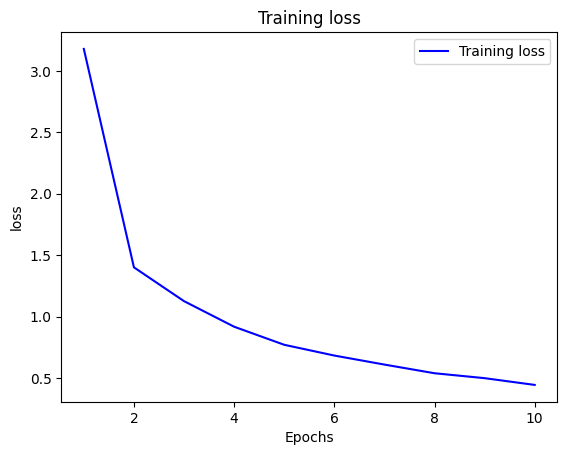

In [24]:
show_model_results_loss_train(results2)

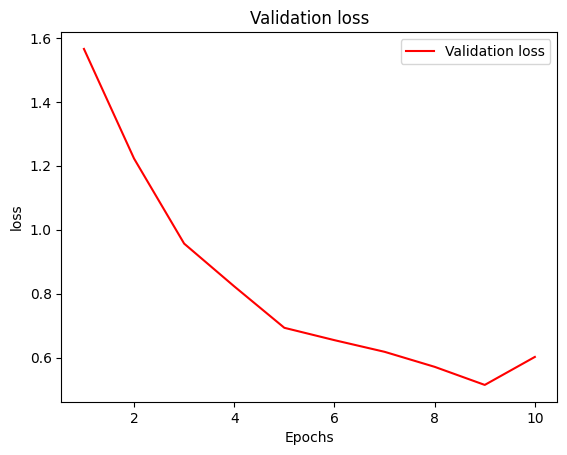

In [26]:
show_model_results_loss_valid(results2)

In [44]:
best_model.save('/content/gdrive/MyDrive/HW02-Practical/overfitmodel.h5')

In [45]:
with open('/content/gdrive/MyDrive/HW02-Practical/overfit_training.pkl', 'wb') as file:
    pickle.dump(results, file)